## Fooling MobileNetV2, pretrained on ImageNet, using PGD

In [2]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [4]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True)
pretrained_model.trainable = False

# ImageNet Labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

Adversarial example will be generated for a Labrador Retriever

In [6]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)

image_probs = pretrained_model.predict(image)

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


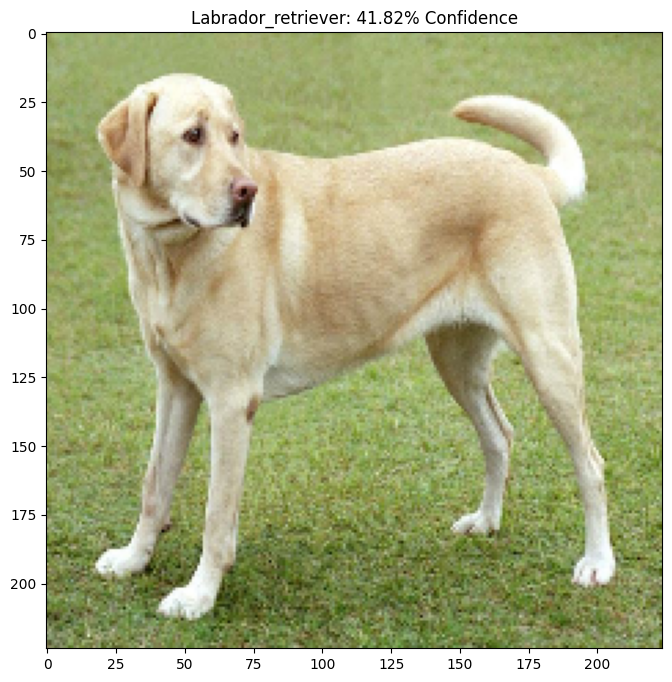

In [7]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{}: {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

Creating the adversarial image with the PGD

In [28]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_pgd_adversary(input_image, input_label, alpha, iterations=10):
  image = tf.identity(input_image)
  for iter in range(iterations):
    image_var = tf.Variable(image)
    with tf.GradientTape() as tape:
      tape.watch(image_var)
      prediction = pretrained_model(image_var)
      loss = loss_object(label, prediction)

    # Gradient w.r.t. input image
    gradient = tape.gradient(loss, image_var)
    # Take sign of gradients to generate perturbation
    signed_grad = tf.sign(gradient)
    image = image + (alpha * signed_grad)
    epsilon = 8/255
    image = tf.clip_by_value(image, input_image - epsilon, input_image + epsilon)

    # # Debugging info for each iteration
    # print(f"Iteration {iter + 1}: Max gradient = {tf.reduce_max(gradient)}, Min gradient = {tf.reduce_min(gradient)}")
    # print(f"Iteration {iter + 1}: Max image value = {tf.reduce_max(image)}, Min image value = {tf.reduce_min(image)}")
  return image

In [9]:
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

In [10]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


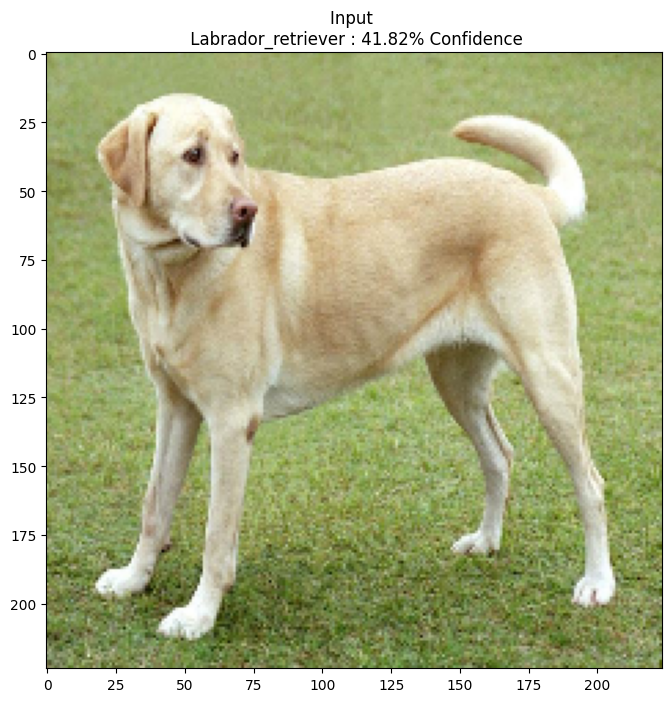

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


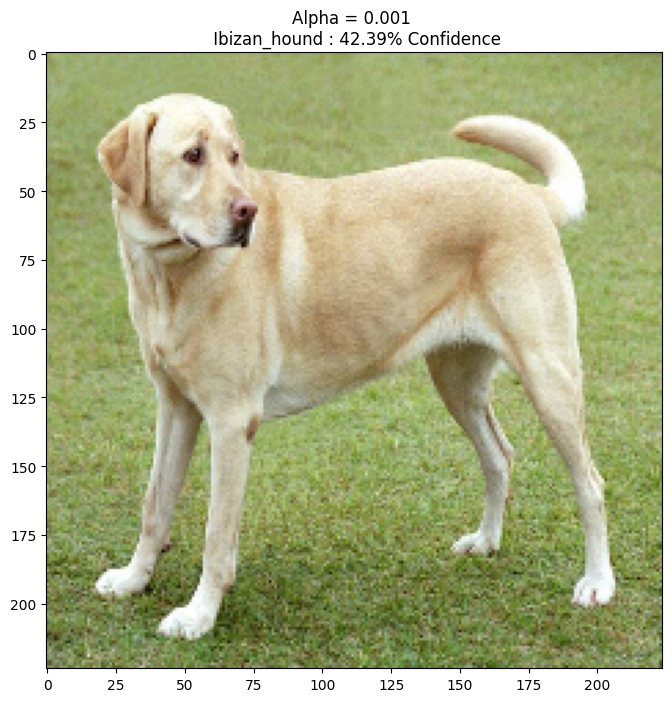

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


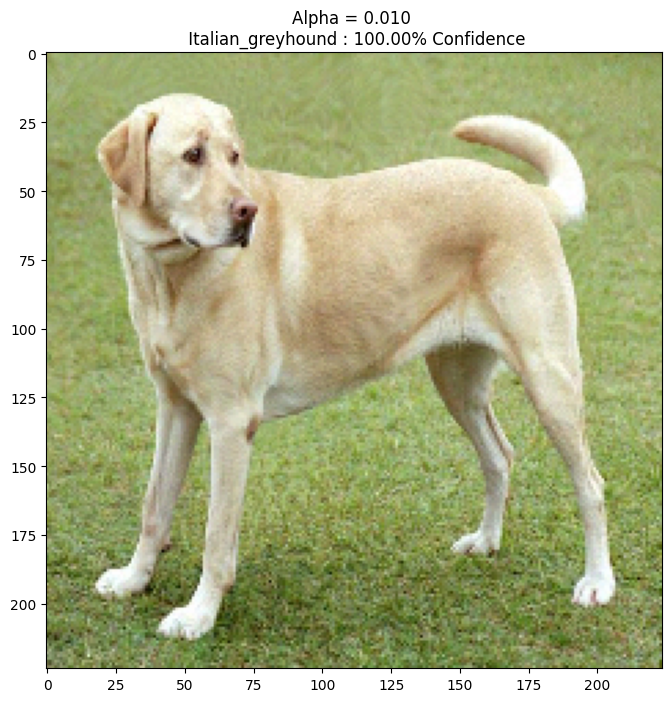

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


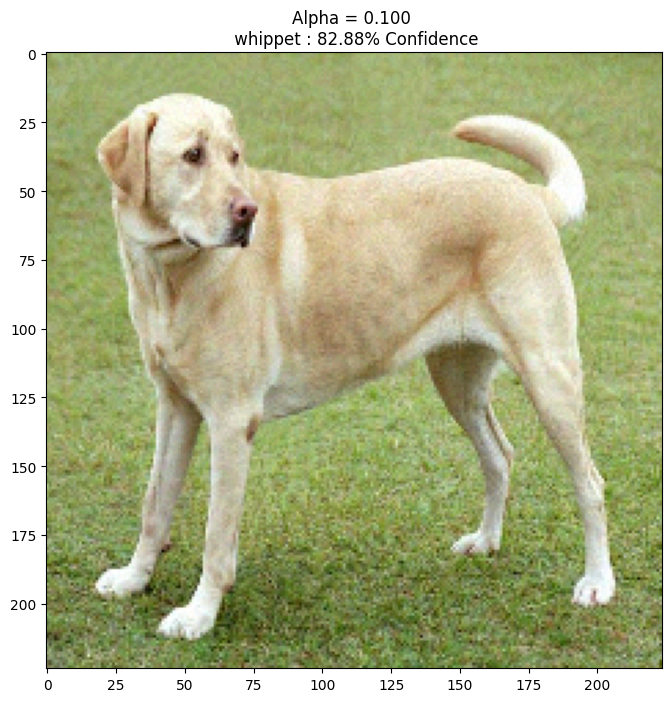

In [30]:
alphas = [0, 0.001, 0.01, 0.1]
descriptions = [('Alpha = {:0.3f}'.format(alp) if alp else 'Input')
                for alp in alphas]

for i, alp in enumerate(alphas):
  adv_x = create_pgd_adversary(image, label, alp)
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])